PROJEKAT 1 - NADGLEDANO UCENJE

Jelena Jakimov
Nikola Vukotic

Zadatak: Klasifikacija - Registrovanje gama cestica u Cherenkov teleskopu

Data set dostupan na linku: https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope

IMPORT SEKCIJA

In [1]:
import os
import pandas as pd
import numpy as np
import joblib as joblib
from abc import ABC
from datetime import datetime
from typing import List, Dict, Any
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import metrics

PREPROCESIRANJE

In [ ]:
df = pd.read_csv("/home/jelena/Desktop/ML_projects/magic04.data",header=None)

In [ ]:
df = df.dropna()

In [ ]:
df[10].replace({'g': 0, 'h': 1}, inplace=True)

In [ ]:
df.rename(columns = {0:'fLength', 1:'fWidth', 2:'fSize', 
                     3:'fConc', 4:'fConc1', 5:'fAsym',
                     6:'fM3Long', 7:'fM3Trans', 8:'fAlpha',
                     9:'fDist', 10:'label'}, inplace = True)

In [ ]:
y = df.pop('label')
X = df

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state = 42)

In [ ]:
X_train['label']=y_train

In [ ]:
X_train=X_train.reset_index()

In [ ]:
X_train.drop('index', inplace=True, axis=1)

In [ ]:
X_test['label']=y_test

In [ ]:
X_test = X_test.reset_index()

In [ ]:
X_test.drop('index', inplace=True, axis=1)

ANALIZA DATA SETA

In [ ]:
df.describe()

In [ ]:
print('NONE VALUES CHECK')
print(df.isna().sum())

In [ ]:
print('HEAT MAP CORRELATION MATRIX')
corrmat = df.corr()
plt.figure(figsize=(20,20))
g=sns.heatmap(df.corr(),annot=True)

NOTE: FConc i FConc1 su visoko korelisani parametri, pa jedan od njih moze biti obrisan. Koristice se FConc parametar.

In [ ]:
df.corr()

SEKCIJA KLASA

In [2]:
class RegressionModelABC(ABC):
    def __init__(self):
        self.data = ['fLength', 'fWidth', 'fSize', 'fConc', 'fAsym', 'fM3Long','fM3Trans','fAlpha','fDist']
        pass

    def train_model(self, data_path_train: str, path_model_store: str, path_standardizer_store: str) -> bool:
        pass

    def run_model(self, data_path_test: str, path_model_store: str, path_standardizer_store: str) -> (bool, List[int]):
        pass
    
    def perform_outlier_detection(df):
        for i in range(df.shape[1]-1):

            param = df.iloc[:, i]
            mean = param.mean()
            std = param.std()
            UCL = mean+2.96*std
            LCL = mean-2.96*std
            q1, q3 = np.percentile(param, [25, 75])
            iqr = q3 - q1
            l_limit = q1 - (iqr * 1.5)
            u_limit = q3 + (iqr * 1.5)

            plt.figure()
            plt.plot(param)
            plt.axhline(y=l_limit, color='r', linestyle='-')
            plt.axhline(y=u_limit, color='r', linestyle='-')
            plt.show()
            for j in range(len(param)):
                if param[j] > UCL:
                    df.iloc[j,i] = UCL
                if param[j] < LCL:
                    df.iloc[j,i] = LCL
        return df


In [3]:
class KNNRegressionModel(RegressionModelABC):
    def __init__(self):
        super().__init__()

    def train_model(self, data_path_train: str, path_model_store: str, path_standardizer_store: str, perform_outlier_det: bool, no_neighb: int) -> bool:
        """
        Method for generating KNN model for classification
        :param data_path_train: path to the model training dataset
        :param path_model_store: path to store the generated model
        :param path_standardizer_store: path to store standardizer - not used for now
        :return: success (True if model generated successfully, else False)
        """
        success = True
        try:
            df = pd.read_csv(data_path_train,header=None)
#             df = pd.read_csv(data_path_train)
            if perform_outlier_det==True:
                df = RegressionModelABC.perform_outlier_detection(df)
            df.replace({'g': 0, 'h': 1}, inplace=True)
            df.rename(columns = {0:'fLength', 
                                 1:'fWidth',
                                 2:'fSize', 
                                 3:'fConc', 
                                 4:'fConc1',
                                 5:'fAsym',
                                 6:'fM3Long',
                                 7:'fM3Trans',
                                 8:'fAlpha',
                                 9:'fDist',
                                 10:'label'}, inplace = True)

            target = df['label']

            x = df[self.data]
            y = target

            knn = KNeighborsClassifier(n_neighbors=no_neighb, n_jobs=-1).fit(x, y)

            joblib.dump(knn, path_model_store)
            
        except Exception as e:
            print(e)
            success = False

        return success

    def run_model(self, data_path_test: str, path_model_store: str, path_standardizer_store: str = None) -> (bool, List[str]):
        """
        Method for running KNN model for classification
        :param data_path_test: path to the model testing dataset
        :param path_model_store: path to load the generated model
        :param path_standardizer_store: path to load the generated standardizer
        :return: success (True if model generated successfully, else False), list of datapoint classes
        """
        success = True
        results = list()
        try:
            knn = joblib.load(path_model_store)

            dfobs = pd.read_csv(data_path_test,header=None)
#             dfobs = pd.read_csv(data_path_test)
#             df_n_obs = dfobs
            df_n_obs = dfobs.replace({'g': 0, 'h': 1})
            df_n_obs.rename(columns = {0:'fLength', 
                                 1:'fWidth',
                                 2:'fSize', 
                                 3:'fConc', 
                                 4:'fConc1',
                                 5:'fAsym',
                                 6:'fM3Long',
                                 7:'fM3Trans',
                                 8:'fAlpha',
                                 9:'fDist',
                                 10:'label'}, inplace = True)
        
            new_obs = df_n_obs[self.data]
            y_test = df_n_obs['label']
            y_pred = knn.predict(new_obs)
            results = list(y_pred)
#             print(df_n_obs.shape)
#             print(y_test.shape)
            print("Metrics:\n", metrics.classification_report(y_test, y_pred))
            metrics.plot_confusion_matrix(knn, new_obs, y_test)
        except Exception as e:
            print(e)
            success = False

        return success, results

In [4]:
class LRRegressionModel(RegressionModelABC):
    def __init__(self):
        super().__init__()

    def train_model(self, data_path_train: str, path_model_store: str, path_standardizer_store: str, perform_outlier_det:bool, hyper_multi_class='multinomial') -> bool:
        """
        Method for generating LR model for classification
        :param data_path_train: path to the model training dataset
        :param path_model_store: path to store the generated model
        :param path_standardizer_store: path to store standardizer
        :return: success (True if model generated successfully, else False)
        """
        success = True
        try:
            df = pd.read_csv(data_path_train,header=None)
#             df = pd.read_csv(data_path_train)
            
            if perform_outlier_det==True:
                df = RegressionModelABC.perform_outlier_detection(df)
            df.replace({'g': 0, 'h': 1}, inplace=True)
            df.rename(columns = {0:'fLength', 
                                 1:'fWidth',
                                 2:'fSize', 
                                 3:'fConc', 
                                 4:'fConc1',
                                 5:'fAsym',
                                 6:'fM3Long',
                                 7:'fM3Trans',
                                 8:'fAlpha',
                                 9:'fDist',
                                 10:'label'}, inplace = True)
            features = df[self.data]

            target = df['label']

            scaler = StandardScaler()
            features_standardized = scaler.fit_transform(features)

            logistic_regression = LogisticRegression(random_state=0, multi_class=hyper_multi_class, solver='lbfgs', max_iter=1000)
            lr = logistic_regression.fit(features_standardized, target)

            joblib.dump(lr, path_model_store)
            joblib.dump(scaler, path_standardizer_store)
        except Exception as e:
            print(e)
            success = False

        return success

    def run_model(self, data_path_test: str, path_model_store: str, path_standardizer_store: str) -> (bool, List[str]):
        """
        Method for running LR model for classification
        :param data_path_test: path to the model testing dataset
        :param path_model_store: path to load the generated model
        :param path_standardizer_store: path to load the generated standardizer
        :return: success (True if model generated successfully, else False), list of datapoint classes
        """
        success = True
        results = list()
        try:
            scaler = joblib.load(path_standardizer_store)
            lr = joblib.load(path_model_store)

            dfobs = pd.read_csv(data_path_test,header=None)
#             dfobs = pd.read_csv(data_path_test)

#             df_n_obs=dfobs
            df_n_obs = dfobs.replace({'g': 0, 'h': 1})
            df_n_obs.rename(columns = {0:'fLength', 
                                 1:'fWidth',
                                 2:'fSize', 
                                 3:'fConc', 
                                 4:'fConc1',
                                 5:'fAsym',
                                 6:'fM3Long',
                                 7:'fM3Trans',
                                 8:'fAlpha',
                                 9:'fDist',
                                 10:'label'}, inplace = True)
            new_obs = df_n_obs[self.data]
            y_test = df_n_obs['label']
            new_obs = scaler.transform(new_obs)

            y_pred = lr.predict(new_obs)
            results = list(y_pred)
            print("Metrics:\n", metrics.classification_report(y_test, y_pred))
            metrics.plot_confusion_matrix(lr, new_obs, y_test)
            
        except Exception as e:
            print(e)
            success = False

        return success, results

In [5]:
class SVMModel(RegressionModelABC):
    def __init__(self):
        super().__init__()

    def train_model(self, data_path_train: str, path_model_store: str, path_standardizer_store: str, perform_outlier_det: bool, kernel="rbf", gamma="auto") -> bool:
        """
        Method for generating LR model for classification
        :param data_path_train: path to the model training dataset
        :param path_model_store: path to store the generated model
        :param path_standardizer_store: path to store standardizer
        :return: success (True if model generated successfully, else False)
        """
        success = True
        try:
            df = pd.read_csv(data_path_train,header=None)
#             df = pd.read_csv(data_path_train)
            
            if perform_outlier_det==True:
                df = RegressionModelABC.perform_outlier_detection(df)
            df.replace({'g': 0, 'h': 1}, inplace=True)
            df.rename(columns = {0:'fLength', 
                                 1:'fWidth',
                                 2:'fSize', 
                                 3:'fConc', 
                                 4:'fConc1',
                                 5:'fAsym',
                                 6:'fM3Long',
                                 7:'fM3Trans',
                                 8:'fAlpha',
                                 9:'fDist',
                                 10:'label'}, inplace = True)
            features = df[self.data]

            target = df['label']

            scaler = StandardScaler()
            features_standardized = scaler.fit_transform(features)

            clf = svm.SVC(kernel = "rbf",gamma="auto", C=100, shrinking=False, probability=False)
            clf_model = clf.fit(features_standardized, target)
        
            joblib.dump(clf_model, path_model_store)
            joblib.dump(scaler, path_standardizer_store)
        except Exception as e:
            print(e)
            success = False

        return success

    def run_model(self, data_path_test: str, path_model_store: str, path_standardizer_store: str) -> (bool, List[str]):
        """
        Method for running KNN model for classification
        :param data_path_test: path to the model testing dataset
        :param path_model_store: path to load the generated model
        :param path_standardizer_store: path to load the generated standardizer
        :return: success (True if model generated successfully, else False), list of datapoint classes
        """
        success = True
        results = list()
        try:
            scaler = joblib.load(path_standardizer_store)
            clf = joblib.load(path_model_store)

            dfobs = pd.read_csv(data_path_test,header=None)
#             dfobs = pd.read_csv(data_path_test)
#             df_n_obs=dfobs
            df_n_obs = dfobs.replace({'g': 0, 'h': 1})
            df_n_obs.rename(columns = {0:'fLength', 
                                 1:'fWidth',
                                 2:'fSize', 
                                 3:'fConc', 
                                 4:'fConc1',
                                 5:'fAsym',
                                 6:'fM3Long',
                                 7:'fM3Trans',
                                 8:'fAlpha',
                                 9:'fDist',
                                 10:'label'}, inplace = True)
            new_obs = df_n_obs[self.data]
            y_test = df_n_obs['label']
            new_obs = scaler.transform(new_obs)

            y_pred = clf.predict(new_obs)
            results = list(y_pred)
            print("Metrics:\n", metrics.classification_report(y_test, y_pred))
            metrics.plot_confusion_matrix(clf, new_obs, y_test)
        except Exception as e:
            print(e)
            success = False

        return success, results

In [6]:
class Worker(object):
    def __init__(self, dict_config):
        self.dict_config = dict_config
        self.data_path_train = self.dict_config['data_path_train']
        self.data_path_test = self.dict_config['data_path_test']
        self.dict_classes = eval(self.dict_config['dict_classes'])
        self.methods_priorities = eval(self.dict_config['lst_methods_priorities'])
        self.knn_model = KNNRegressionModel()
        self.lr_model = LRRegressionModel()
        self.svm_model = SVMModel()
        self.lst_keys_process = list()


    def _run_knn(self) -> (bool, List[int]):
        """
        Method that performs KNN 
        :return: Success status, list of classes per index
        """
        knn_operations = self.dict_config['knn_operations']
        knn_model_store = self.dict_config['knn_model_store']
        knn_active = self.dict_config['knn_active']
        success = False
        results = list()
        if knn_active == 'True':
            print(f'KNN processing started at {datetime.now()}')
            if knn_operations == 'train_test':
                
                print('1# Starting KNN training and testing')
                success = self.knn_model.train_model(self.data_path_train, knn_model_store,'',False,1)
                if success is False:
                    print('KNN model not trained properly')
                    return success, results
                success, results = self.knn_model.run_model(self.data_path_test, knn_model_store)
                if success is False:
                    print('KNN model not executed properly')
                    
#                 print('2# Starting KNN training and testing')
#                 success = self.knn_model.train_model(self.data_path_train, knn_model_store,'',False,3)
#                 if success is False:
#                     print('KNN model not trained properly')
#                     return success, results
#                 success, results = self.knn_model.run_model(self.data_path_test, knn_model_store)
#                 if success is False:
#                     print('KNN model not executed properly')

            else:
                print('Undefined operations flag for KNN')

            print(f'KNN processing ended at {datetime.now()}')
        return success, results

    def _run_lr(self) -> (bool, List[int]):
        """
        Method that performs MLR 
        :return: Success status, list of classes per index
        """
        lr_operations = self.dict_config['lr_operations']
        lr_model_store = self.dict_config['lr_model_store']
        lr_path_standardizer_store = self.dict_config['lr_path_standardizer_store']
        lr_active = self.dict_config['lr_active']
        success = False
        results = list()
        if lr_active == 'True':
            print(f'LR processing started at {datetime.now()}')
            if lr_operations == 'train_test':
                print('Starting LR training and testing')
                success = self.lr_model.train_model(self.data_path_train, lr_model_store, lr_path_standardizer_store, True, 'auto')
                if success is False:
                    print('LR model not trained properly')
                    return success, results
                
                success, results = self.lr_model.run_model(self.data_path_test, lr_model_store, lr_path_standardizer_store)
                if success is False:
                    print('LR model not executed properly')

            elif lr_operations == 'train':
                print('Starting LR training')
                success = self.lr_model.train_model(self.data_path_train, lr_model_store, lr_path_standardizer_store)
                if success is False:
                    print('LR model not trained properly')
            elif lr_operations == 'test':
                print('Starting LR testing')
                if os.path.exists(lr_model_store) is False:
                    print('LR model not existing')
                elif os.path.exists(lr_path_standardizer_store) is False:
                    print('LR model standardizer not existing')
                else:
                    success, results = self.lr_model.run_model(self.data_path_test, lr_model_store, lr_path_standardizer_store)
                    if success is False:
                        print('LR model not executed properly')
            else:
                print('Undefined operations flag for LR')

            print(f'LR processing ended at {datetime.now()}')
        return success, results
    
    def _run_svm(self) -> (bool, List[int]):
        """
        Method that performs SVM 
        :return: Success status, list of classes per index
        """
        svm_operations = self.dict_config['svm_operations']
        svm_model_store = self.dict_config['svm_model_store']
        svm_path_standardizer_store = self.dict_config['svm_path_standardizer_store']
        svm_active = self.dict_config['svm_active']
        success = False
        results = list()
        if svm_active == 'True':
            print(f'SVM processing started at {datetime.now()}')
            if svm_operations == 'train_test':
                print('Starting SVM training and testing')
                success = self.svm_model.train_model(self.data_path_train, svm_model_store, svm_path_standardizer_store, False)
                if success is False:
                    print('SVM model not trained properly')
                    return success, results
                success, results = self.svm_model.run_model(self.data_path_test, svm_model_store, svm_path_standardizer_store)
                if success is False:
                    print('SVM model not executed properly')

            else:
                print('Undefined operations flag for SVM')

            print(f'SVM processing ended at {datetime.now()}')
            
        return success, results



    def _get_combined_results(self, dct_df: Dict[str, List[Any]], lst_keys_process: List[str], no_timestamps: int) -> Dict[str, List[Any]]:
        """
        Method that make combination of the results per analysis
        :param dct_df: Dictionary of results per method
        :param lst_keys_process: List of analysis keys to process
        :param no_timestamps: Number of timestamps in data to process
        :return: Dictionary of final decision results and confidence
        """
        ret_dict = dict()
        if len(lst_keys_process) > 0:
            for i in range(no_timestamps):
                lst_classes = [dct_df[method][i] for method in lst_keys_process]

                dct_occurrences = {item: lst_classes.count(item) for item in set(lst_classes)}
                dct_occurrences = dict(sorted(dct_occurrences.items(), key=lambda item: item[1], reverse=True))
                most_common_class = list(dct_occurrences.keys())[0]
                most_common_no_occurrences = list(dct_occurrences.values())[0]

                percentage = round(most_common_no_occurrences / len(lst_classes), 2)
                if percentage <= 0.50:
                    most_common_class = self._perform_priority_voting(dct_df, i, dct_occurrences, most_common_no_occurrences)

                if 'decision_class' not in ret_dict:
                    ret_dict['decision_class'] = list()
                ret_dict['decision_class'].append(most_common_class)

                if 'percentage' not in ret_dict:
                    ret_dict['percentage'] = list()
                ret_dict['percentage'].append(percentage)

        return ret_dict

    def _generate_results(self, timestamps: List[int], knn_results: List[int], lr_results: List[int], svm_results: List[int]) -> pd.DataFrame:
        """
        Performs results generation for all analysis
        :param timestamps: List of timestamps of data to process
        :param knn_results: List of KNN results of data to process
        :param lr_results: List of LR results of data to process
        :param svm_results: List of SVM results of data to process
        :return: Dictionary of classes per timestamp per analysis
        """
        dct_df = dict()
        no_timestamps = len(timestamps)
        dct_df['timestamp'] = timestamps
        self.lst_keys_process = list()

        if len(knn_results) == len(timestamps):
            dct_df['knn'] = knn_results
            self.lst_keys_process.append('knn')
        else:
            print('KNN results will not participate in final decision due to data length mismatch')

        if len(lr_results) == len(timestamps):
            dct_df['lr'] = lr_results
            self.lst_keys_process.append('lr')
        else:
            print('LR results will not participate in final decision due to data length mismatch')
        
        if len(svm_results) == len(timestamps):
            dct_df['svm'] = svm_results
            self.lst_keys_process.append('svm')
        else:
            print('SVM results will not participate in final decision due to data length mismatch')

        
        combined_results_dict = self._get_combined_results(dct_df, self.lst_keys_process, no_timestamps)

        if len(combined_results_dict) > 0:
            dct_df.update(combined_results_dict)

        rez_df = pd.DataFrame.from_dict(dct_df, orient='columns')
        rez_df.set_index('timestamp', inplace=True)
        rez_df.sort_index(inplace=True)
        return rez_df

    
    def _get_testing_timestamps(self) -> List[str]:
        """
        Method that gets timestamps of data for processing
        :return: List of timestamps of data for processing
        """
        testing_df = pd.read_csv(self.data_path_test,header=None)
        timestamps = list(testing_df.index)
        return timestamps


    def perform_all_analysis(self) -> pd.DataFrame:
        """
        Perform all analysis and combine results
        :return: Dataframe of final results
        """
        timestamps = self._get_testing_timestamps()
        knn_success, knn_results = self._run_knn()
        lr_success, lr_results = self._run_lr()
        svm_success, svm_results = self._run_svm()

        df = self._generate_results(timestamps, knn_results, lr_results, svm_results)

        return df
    
    def _perform_priority_voting(self, dct_df: Dict[str, List[Any]], i: int, dct_occurrences: Dict[int, int], most_common_no_occurrences: int) -> int:
        """
        Performs additional priority voting if initial voting is not completely clear
        :param dct_df: Dictionary of results per method
        :param i: Index of timestamp to check
        :param dct_occurrences: Dictionary of classes occurrences
        :param most_common_no_occurrences: Number of occurrences for classes that appears in most cases
        :return: Index of final decision class
        """
        ret_index = -1
        ts = dct_df['timestamp'][i]
        classes_keys = [key for key in dct_occurrences if dct_occurrences[key] == most_common_no_occurrences]
        if len(classes_keys) > 1:
            for key in self.methods_priorities:
                if key in dct_df:
                    method_index = dct_df[key][i]
                    if method_index in classes_keys:
                        ret_index = method_index
                        break
        else:
            ret_index = classes_keys[0]

        print(f'Voting performed for timestamp {ts}')

        return ret_index


Processing started at 2022-01-21 11:40:04.471914
ok
KNN processing started at 2022-01-21 11:40:04.529273
1# Starting KNN training and testing
Metrics:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     12332
           1       1.00      1.00      1.00      6688

    accuracy                           1.00     19020
   macro avg       1.00      1.00      1.00     19020
weighted avg       1.00      1.00      1.00     19020

KNN processing ended at 2022-01-21 11:40:06.688711
LR processing started at 2022-01-21 11:40:06.688806
Starting LR training and testing


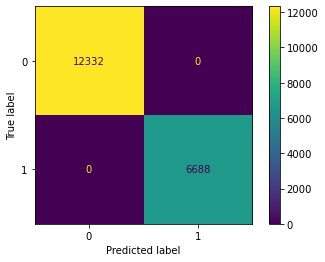

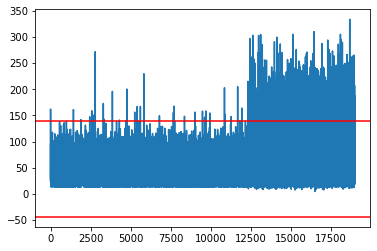

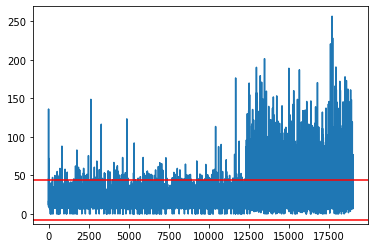

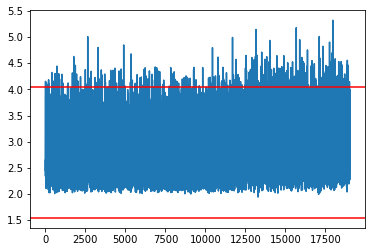

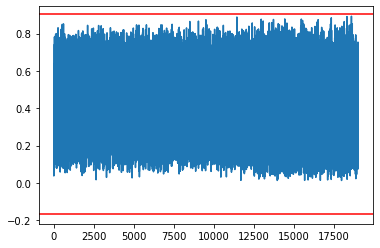

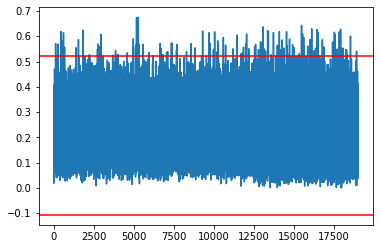

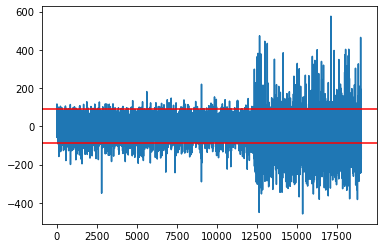

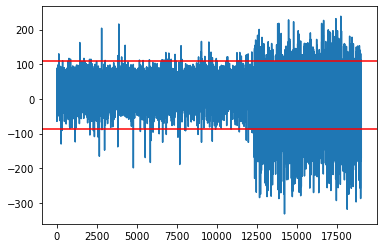

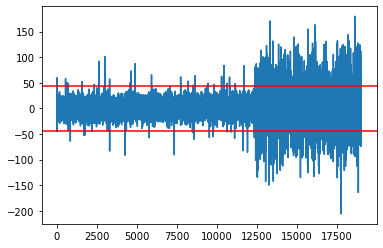

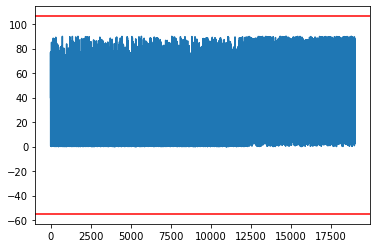

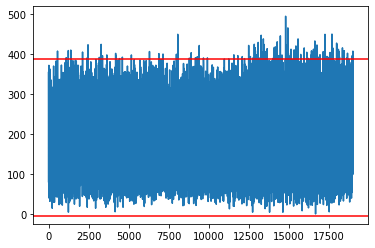

Metrics:
               precision    recall  f1-score   support

           0       0.80      0.90      0.85     12332
           1       0.76      0.59      0.66      6688

    accuracy                           0.79     19020
   macro avg       0.78      0.74      0.76     19020
weighted avg       0.79      0.79      0.78     19020

LR processing ended at 2022-01-21 11:40:12.215066
SVM processing started at 2022-01-21 11:40:12.215156
Starting SVM training and testing


KeyboardInterrupt: 

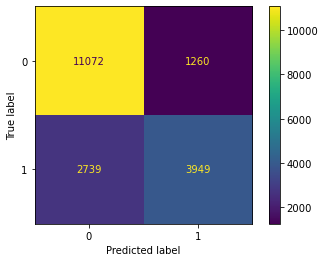

In [7]:
import configparser

def read_and_check_config():
    config = configparser.ConfigParser()
    parsed_file = config.read(os.getcwd() + '/config.ini')
    if not parsed_file:
        raise Exception()
    section = config.get('DEFAULT', 'section')
    config_d = dict(config.items(section))

    return config_d


print(f'Processing started at {datetime.now()}')
status = 'Successful'
try:
    config_dict = read_and_check_config()
    print('ok')
    path_store_csv = config_dict['out_table_csv_path']

    worker = Worker(dict_config=config_dict)

    df_analysis = worker.perform_all_analysis()
#     df_analysis.to_csv(path_store_csv)

except Exception as e:
    print(f'While processing, the following error occurred {e}')
    status = 'Unsuccessful'

print(f'{status} processing finished at {datetime.now()}')
